In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

# Warning suppression
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
df = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X = df.copy().drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

In [4]:
df['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

In [5]:
vif_list = utils.vif_removal_priority(X, 10)
vif_list

[['Education', 29.507416450234114],
 ['CholCheck', 22.235530259486595],
 ['AnyHealthcare', 18.1270116599421],
 ['BMI', 14.66476984201411]]

In [6]:
X = X.drop(['CholCheck', 'Education', 'AnyHealthcare', 'BMI'], axis=1)
X.head()

,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,3.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,8.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,6.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,4.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.5)
print(len(X_train))

126840


In [8]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(len(X_resampled))

35494


In [9]:
print(len(X_test))

126840


In [9]:
svc = utils.create_model(utils.Model.SVC, {'random_state': 42})
svc_us = utils.create_model(utils.Model.SVC, {'random_state': 42})

svc.fit(X_train, y_train)
svc_us.fit(X_resampled, y_resampled)

pred = svc.predict(X_test)
pred_us = svc_us.predict(X_test)

results = []

results.append({
    'name': 'Baseline SVC',
    'acc_score': accuracy_score(y_test, pred),
    'train_score': svc.score(X_train, y_train),
    'test_score': svc.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred)
})
results.append({
    'name': 'Undersampled SVC',
    'acc_score': accuracy_score(y_test, pred_us),
    'train_score': svc_us.score(X_resampled, y_resampled),
    'test_score': svc_us.score(X_test, y_test),
    'balanced_score': balanced_accuracy_score(y_test, pred_us)
})

results_df = pd.DataFrame(results) #.sort_values('score', ascending=False)
results_df

# 	name	            acc_score	train_score	test_score	balanced_score
# 0	Baseline SVC	    0.861826	0.860281	0.861826	0.500000
# 1	Undersampled SVC	0.678272	0.732498	0.678272	0.735252

,name,acc_score,train_score,test_score,balanced_score
0,Baseline SVC,0.861826,0.860281,0.861826,0.500000
1,Undersampled SVC,0.678272,0.732498,0.678272,0.735252


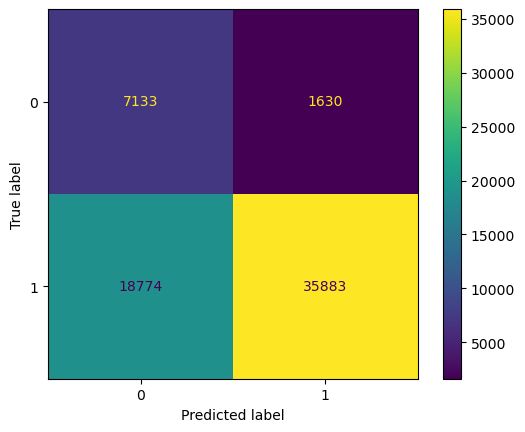

In [10]:
cmd = utils.confusion_matrix_plot(y_test, pred_us, [1, 0])
cmd.plot()

In [9]:
# 5m 25.5s
svc_linear = utils.create_model(utils.Model.SVC, {'random_state': 42, 'kernel': 'linear'})
svc_linear.fit(X_resampled, y_resampled)

SVC(kernel='linear')

In [10]:
# 25.9s
pred_linear = svc_linear.predict(X_test)

In [11]:
print(classification_report(y_test, pred_linear,
                            target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.95      0.68      0.80     54657
    positive       0.29      0.79      0.42      8763

    accuracy                           0.70     63420
   macro avg       0.62      0.74      0.61     63420
weighted avg       0.86      0.70      0.74     63420



In [14]:
# 45.1s
svc_poly = utils.create_model(utils.Model.SVC, {'random_state': 42, 'kernel': 'poly'})
svc_poly.fit(X_resampled, y_resampled)

SVC(kernel='poly')

In [15]:
# 38.7s
pred_poly = svc_poly.predict(X_test)

In [16]:
print(classification_report(y_test, pred_poly,
                            target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.95      0.72      0.82     54657
    positive       0.30      0.75      0.43      8763

    accuracy                           0.72     63420
   macro avg       0.62      0.73      0.62     63420
weighted avg       0.86      0.72      0.76     63420



In [10]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], #, 1000],  
    'gamma': [1, 0.1, 0.01], #, 0.001, 0.0001], 
    'kernel': ['poly']
    # coef0, degree
}

svc_poly_grid = SVC()
grid = RandomizedSearchCV(svc_poly_grid, param_grid, verbose=3, n_jobs=8)
grid.fit(X_resampled, y_resampled)

# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# [CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  29.4s
# [CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  30.8s
# [CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  30.3s
# [CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  30.6s
# [CV] END .......................C=1, gamma=0.01, kernel=poly; total time=  30.2s
# [CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time= 2.9min
# [CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time= 3.2min
# [CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time= 5.2min
# [CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time= 5.9min
# [CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time= 2.9min
# [CV] END ......................C=10, gamma=0.01, kernel=poly; total time= 4.4min
# [CV] END ......................C=10, gamma=0.01, kernel=poly; total time= 3.6min

Fitting 5 folds for each of 10 candidates, totalling 50 fits
